In [1]:
import torch as th

import matplotlib.pyplot as plt
import time

import sys
import os
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches
import cv2
import pandas as pd
from svgpathtools import parse_path
import svg_distance_helpers as rsh
import torch
from torch.autograd import Variable
import SimpleITK as sitk
#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
import airlab as al
from torch.autograd import Variable
import affine_registration_2d as ar

In [2]:
# directory & file hierarchy
analysis_dir = os.getcwd()
data_dir = os.path.join(analysis_dir,"photodraw_tracing")
ref_dir = os.path.join(analysis_dir, 'tracing_ref')
trans_dir = os.path.join(analysis_dir, 'transformed')

canvas_side = 432 # image size
rows, cols = canvas_side, canvas_side # the size of a given drawing image
tracing = ['this square','this shape', 'this circle']

In [3]:
# prepare lists for dataframe construction
age = []
sessionid = []
trace_item = []
pre_mse = []
post_mse = []
rotate = []
translate = []
scale = []

In [4]:
# generate reference shapes
really_run_this = 1
if really_run_this:
    ref_path = []
    for t in tracing:
        fname = os.path.join(ref_dir, '{}.png'.format(t))
        img_ref = cv2.imread(fname)
        img_ref = rsh.color_to_num(img_ref, threshold=0, white_background=False)
        ofname = os.path.join(ref_dir, '{}_ref.png'.format(t))
        cv2.imwrite(ofname, 255-img_ref*255)
        ref_path.append(ofname)
    

In [5]:
reload(al)
reload(ar)
# get tracings from the data folder
for child_dir in os.listdir(data_dir):
    if child_dir.startswith('CDM'):
        child_info = child_dir.split('_')
        c_age = int(child_info[-1].replace('age',''))
        c_sessionid = child_info[2]

        for ti, t in enumerate(tracing):
            img_draw = os.path.join(data_dir, child_dir, '{}.png'.format(t))
            
            if os.path.exists(img_draw):
                img_ref = ref_path[ti]
                init_loss, final_loss, ro, tran, s, warped = ar.affine_reg(img_draw, img_ref)
                cv2.imwrite(os.path.join(trans_dir, 'warp_{}_{}.png'.format(img_draw, c_sessionid)), warped.numpy())
                
                # prepare the dataframe
                age.append(c_age)
                sessionid.append(c_sessionid)
                trace_item.append(t)
                pre_mse.append(init_loss)
                post_mse.append(final_loss)
                rotate.append(ro)
                translate.append(tran)
                scale.append(s)

In [6]:
print age

[7, 7, 7, 4, 4, 5, 5, 5, 7, 7, 7, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 7, 7, 7, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 6, 7, 7, 7, 6, 6, 6, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 7, 7, 7, 5, 5, 5, 6, 6, 6, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4]


In [7]:
really_run_this = 1 
## compile data
if really_run_this:
    data = pd.DataFrame([sessionid, age, trace_item, pre_mse, post_mse, rotate, translate, scale])
    data = data.transpose()
    data.columns = ['session_id','age', 'tracing_item', 'pre_mse', 'post_mse', 'rotate', 'translate', 'scale']
    
## save out the data
data.to_csv("photodraw_tracing.csv")

#### Data Visualization

In [ ]:
really_run_this = 1 

if really_run_this:
    data = pd.read_csv('photodraw_tracing.csv')

- X axis: Age        
- Y axis: pre/post-mse

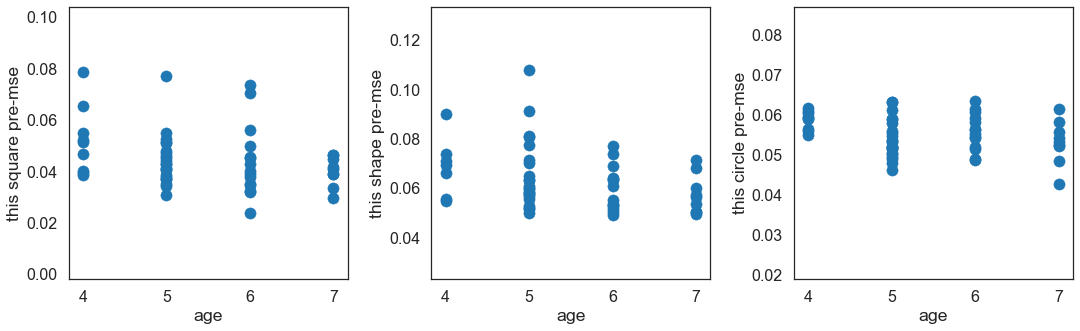

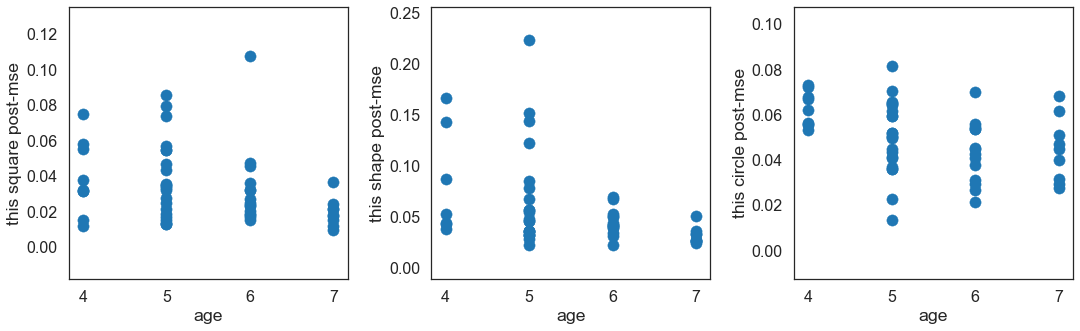

In [8]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['pre_mse'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' pre-mse')
    plt.xlabel('age')
    
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['post_mse'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' post-mse')
    plt.xlabel('age')


- X axis: Pre-mse
- Y axis: Post-mse  
- Age: different colors

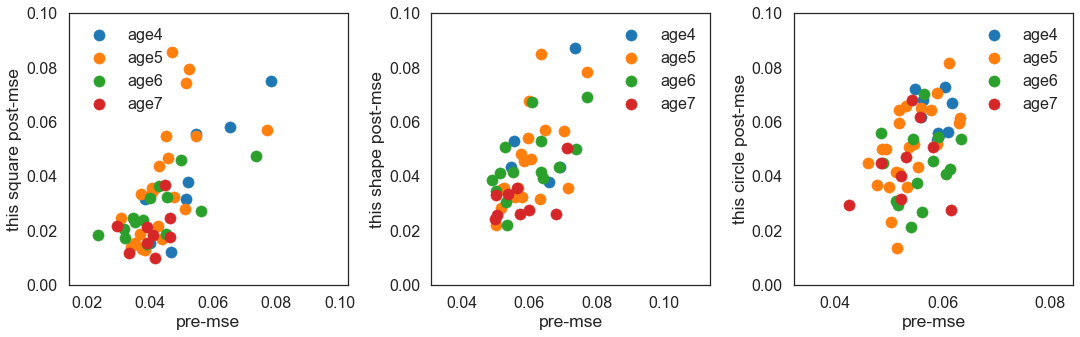

In [9]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    plt.subplot(1,3,ti+1)
    plt.ylabel(t +' post-mse')
    plt.xlabel('pre-mse')
    plt.ylim((0.0, 0.1))
    
    for age in range(4, 8):
        current_trace = data.loc[(data['age'] == age) &(data['tracing_item'] == t)]
        pre_mse_list = []
        post_mse_list = []
        
        for index, row in current_trace.iterrows():
            pre_mse_list.append(row['pre_mse'])
            post_mse_list.append(row['post_mse'])

        h = plt.scatter(pre_mse_list, post_mse_list, label='age'+str(age))
    
    plt.legend()


- X axis: Age        
- Y axis: rotation

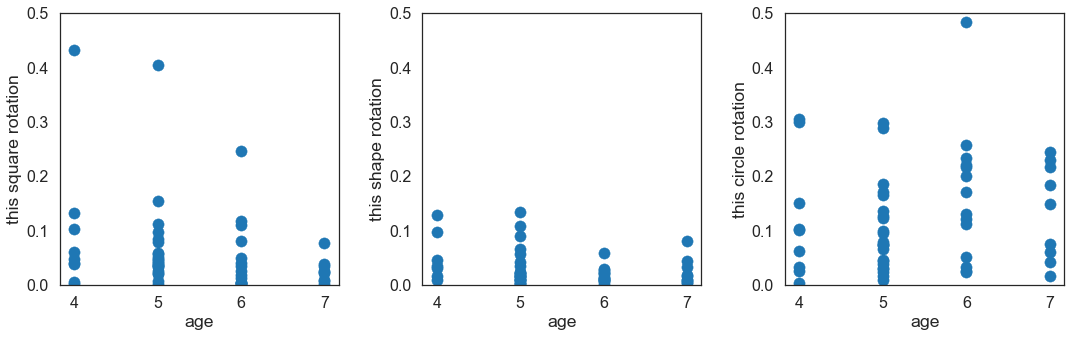

In [10]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['rotate'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' rotation')
    plt.xlabel('age')
    plt.ylim((0.0, 0.5))

- X axis: Age        
- Y axis: translation

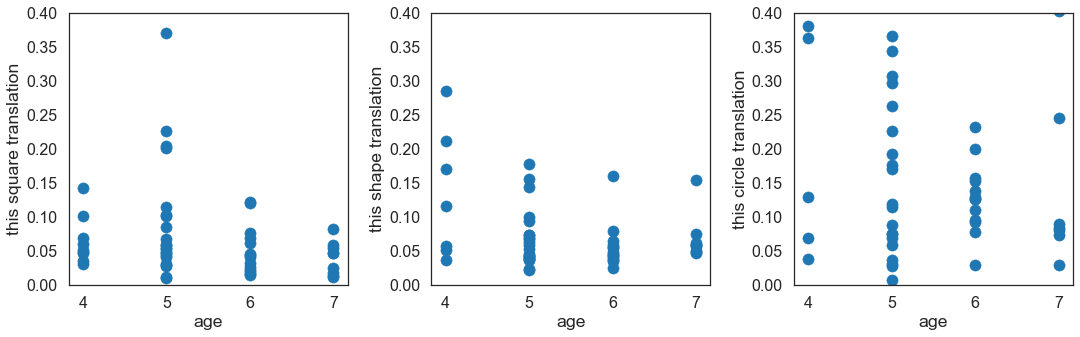

In [11]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['translate'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' translation')
    plt.xlabel('age')
    plt.ylim((0.0, 0.4))

- X axis: Age
- Y axis: Scaling

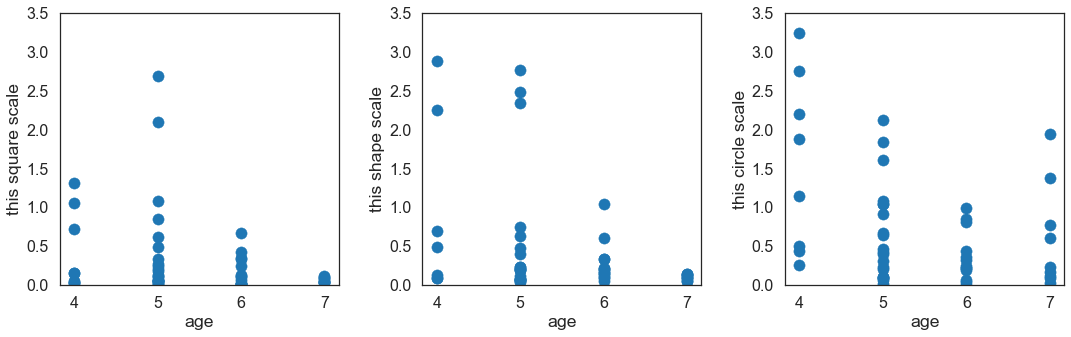

In [15]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['scale'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' scale')
    plt.xlabel('age')
    plt.ylim((0, 3.5))

#### Tracing and Recognition

In [ ]:
# get recognition correction percentage
recog = pd.read_csv('photodraw_recognition_ratings.csv')
all_sessions = data.session_id.unique()

data['correct'] = 0

for index, id in enumerate(all_sessions):
    rec_col = recog.loc[(recog['sessionId'] == id)]
    if rec_col.shape[0] == 0:
        data.loc[data['session_id'] == id, ['correct']] = 0
        continue
    rec_correct_percent = rec_col.loc[(rec_col['correct'])].shape[0]/rec_col.shape[0]
    data.loc[data['session_id'] == id, ['correct']] = rec_correct_percent

data.to_csv("photodraw_tracing.csv")

In [ ]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    plt.subplot(1,3,ti+1)
    plt.ylabel(' correct percent')
    plt.xlabel(t +' pre-mse')
    plt.xlim(0.0,0.1)
    plt.ylim(0.0,1.0)
    
    for age in range(4, 8):
        current_trace = data.loc[(data['age'] == age) &(data['tracing_item'] == t)]
        pre_mse_list = []
        correct = []
        
        for index, row in current_trace.iterrows():
            pre_mse_list.append(row['pre_mse'])
            correct.append(row['correct'])

        h = plt.scatter(pre_mse_list, correct, label='age'+str(age))
    
    plt.legend()


plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    plt.subplot(1,3,ti+1)
    plt.ylabel('correct percent')
    plt.xlabel(t +' post-mse')
    plt.xlim(0.0,0.1)
    plt.ylim(0.0,1.0)
    
    for age in range(4, 8):
        current_trace = data.loc[(data['age'] == age) &(data['tracing_item'] == t)]
        post_mse_list = []
        correct = []
        
        for index, row in current_trace.iterrows():
            post_mse_list.append(row['post_mse'])
            correct.append(row['correct'])

        h = plt.scatter(post_mse_list, correct, label='age'+str(age))
    
    plt.legend()

